# **Sequence-to-Sequence Modelling**

Sequence-to-Sequence (Seq2Seq) modelling is about training the models that can convert sequences from one domain to sequences of another domain, for example, English to French. This Seq2Seq modelling is performed by the LSTM encoder and decoder. We can guess this process from the below illustration. 

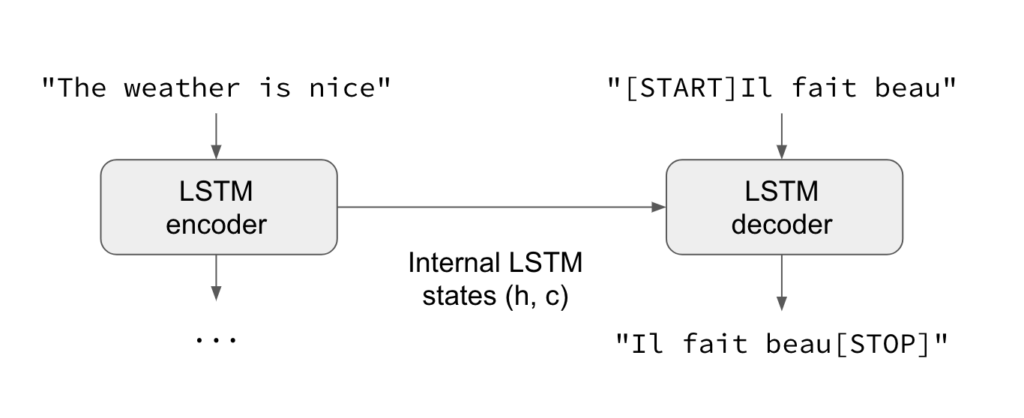

In this session, we will implement deep learning in the Sequence-to-Sequence (Seq2Seq) modelling for language translation. This approach will be applied to convert the short English sentences into the corresponding French sentences. The LSTM encoder and decoder are used to process the sequence to sequence modelling in this task. 

## **Data Set**

In this experiment, the data set is taken from Kaggle that is publically available as [French-English Bilingual Pairs](https://www.kaggle.com/jannesklaas/frenchenglish-bilingual-pairs). This dataset contains pairs of French sentences as well as their English translation

## **Implementation of Sequence-to-Sequence (Seq2Seq) Modelling**

First of all, we will import the required libraries. 

In [ ]:
!python -m pip install pip --upgrade --user -q --no-warn-script-location
!python -m pip install numpy pandas seaborn matplotlib scipy statsmodels sklearn tensorflow keras nltk gensim --user -q --no-warn-script-location

import IPython
IPython.Application.instance().kernel.do_shutdown(True)

In [ ]:
#Importing library
import numpy as np
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.utils import *
from keras.initializers import *
import tensorflow as tf
import time, random
from keras.optimizers import Adam

After importing the libraries, we will specify the value for the hyperparameters including the batch size for training, latent dimensionality for the encoding space and the number of samples to train on.

In [ ]:
#Hyperparameters
batch_size = 64
latent_dim = 256
num_samples = 10000

The below lines of codes will perform the data vectorization where we will read the file containing the English and corresponding French sentences. In the vectorization process, the collection of text documents is converted into feature vectors.

In [ ]:
#Vectorize the data.
input_texts = []
target_texts = []
input_chars = set()
target_chars = set()

with open('fra.txt', 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_chars:
            input_chars.add(char)
    for char in target_text:
        if char not in target_chars:
            target_chars.add(char)

input_chars = sorted(list(input_chars))
target_chars = sorted(list(target_chars))
num_encoder_tokens = len(input_chars)
num_decoder_tokens = len(target_chars)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

#Print size
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

After getting the data set with all features, we will define the input data encoder and decoder and the target data for the decoder.

In [ ]:
#Define data for encoder and decoder
input_token_id = dict([(char, i) for i, char in enumerate(input_chars)])
target_token_id = dict([(char, i) for i, char in enumerate(target_chars)])

encoder_in_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype='float32')

decoder_in_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')

decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_in_data[i, t, input_token_id[char]] = 1.
    for t, char in enumerate(target_text):
        decoder_in_data[i, t, target_token_id[char]] = 1.
        if t > 0:
            decoder_target_data[i, t - 1, target_token_id[char]] = 1.

Below lines of codes will define the input sequence for the encoder defined above and process this sequence. After that, an initial state will be set up for the decoder using ‘encoder_states’.

In [ ]:
#Define and process the input sequence
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
#We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

#Using `encoder_states` set up the decoder as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

The below line of code will define the final model that will turn `encoder_in_data` & `decoder_in_data` into `decoder_target_data`.

In [ ]:
#Final model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

After defining the final model, we will check it by its summary, data shape and a visualization.

In [ ]:
#Model Summary
model.summary()

In [ ]:
#Model data Shape
print("encoder_in_data shape:",encoder_in_data.shape)
print("decoder_in_data shape:",decoder_in_data.shape)
print("decoder_target_data shape:",decoder_target_data.shape)

In [ ]:
#Visuaize the model
#plot_model(model,show_shapes=True)
#sequence to sequence modeling for language translation using deep learning

Once we are ready with the final model, we will compile and train the model. Here, the model will be trained in 50 epochs only. For more accuracy, you can perform this for more number of epochs.

In [ ]:
#Compiling and training the model
model.compile(optimizer=Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.001), loss='categorical_crossentropy')

model.fit([encoder_in_data, decoder_in_data], decoder_target_data, batch_size = batch_size, epochs=50, validation_split=0.2)

After successful training, we will define the sample model using the parameters of the trained model to test language translation.

In [ ]:
#Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

The below part of codes will define the decode sequence for the text that we will pass to the model as the input sequence. This could be understood as the module for translating the input language into the target language. In this part, the input sequence is encoded into the state vectors. The state vector and the target sequence is passed to the decoder and it produces the prediction for the next character. Using these predictions, the next character is sampled and it is appended to the target sequence. This process is repeated to generate until the end of the sequence.

In [ ]:
reverse_input_char_index = dict((i, char) for char, i in input_token_id.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_id.items())

#Define Decode Sequence
def decode_sequence(input_seq):
    #Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    #Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    #Get the first character of target sequence with the start character.
    target_seq[0, 0, target_token_id['\t']] = 1.

    #Sampling loop for a batch of sequences
    #(to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        #Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        #Exit condition: either hit max length
        #or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        #Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        #Update states
        states_value = [h, c]

    return decoded_sentence

Finally, we will check our model to decode the input sequence into the target sequence, i.e., translate the English sentences into the French sentences.

In [ ]:
for seq_index in range(10):
    input_seq = encoder_in_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

# **Related Articles:**

> * [Sequence-to-Sequence Modeling using LSTM for Language Translation](https://analyticsindiamag.com/sequence-to-sequence-modeling-using-lstm-for-language-translation/)

> * [Text Generation using RNN](https://analyticsindiamag.com/recurrent-neural-network-in-pytorch-for-text-generation/)

> * [SVD in Recommender System](https://analyticsindiamag.com/singular-value-decomposition-svd-application-recommender-system/)

> * [TF-IDF from Scratch in Python](https://analyticsindiamag.com/hands-on-implementation-of-tf-idf-from-scratch-in-python/)

> * [Continuous Bag of Words](https://analyticsindiamag.com/the-continuous-bag-of-words-cbow-model-in-nlp-hands-on-implementation-with-codes/)

> * [NLP Case Study of Documents Similarity](https://analyticsindiamag.com/nlp-case-study-identify/)


